# Data Analysis Interview Challenge
Burns, Echelle  --   2020 January

## Part 1: Exploratory Data Analysis

Prompt: The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them. 

In [1]:
# Import packages

# For data manipulation
import pandas as pd
import datetime as dt
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors as mcolors

# For statistics
import scipy
import statsmodels.api as sm

In [2]:
# Define useful functions
def plot_results(anova_model): 
    """ Plots results from an ANOVA output, lines that overlap on X axis are """
    """ statistically similar """
    CI = anova_model.conf_int() # get confidence interval of ANOVA model
    int_value = anova_model.params['intercept'] # get the intercept value
    newrow = [CI.loc['intercept',0]-int_value, CI.loc['intercept',1]-int_value]
        # get the new x values for the intercept, centered around 0
    CI.loc['intercept'] = newrow # overwrite the intercept line
    CI = CI.reset_index() # reset the index so we can have feature names
    height = len(CI) # get the length of the CI 
    color = list(mcolors.BASE_COLORS) # get a list of the base colors
    for row in range(len(CI)): # for each factor in the model
        plt.plot(list(CI.iloc[row, 1:]), [height, height], color=color[row], 
                 label=CI.iloc[row,0])
            # plot the x start and x end values, with the same height, and color
            # according to factor value; label as factor value
        height -= 1 # remove 1 for height and plot again
    plt.yticks([]) # y axis is only used to disperse points so they don't overlap
    plt.legend() # add a legend
    plt.xlabel('95% CI') # explain the x axis
    plt.show() # show the plot

In [3]:
# Load in dataset
logins = pd.read_json('ultimate_challenge/logins.json')

# Group into 15 intervals and count the number of occurences
logins.login_time = pd.to_datetime(logins.login_time, errors='coerce')
counts = logins.resample('15min', on='login_time').agg('count')
counts.columns = ['count_ind'] # rename the column
counts = counts.reset_index() # reset the index

C:\Users\echel\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


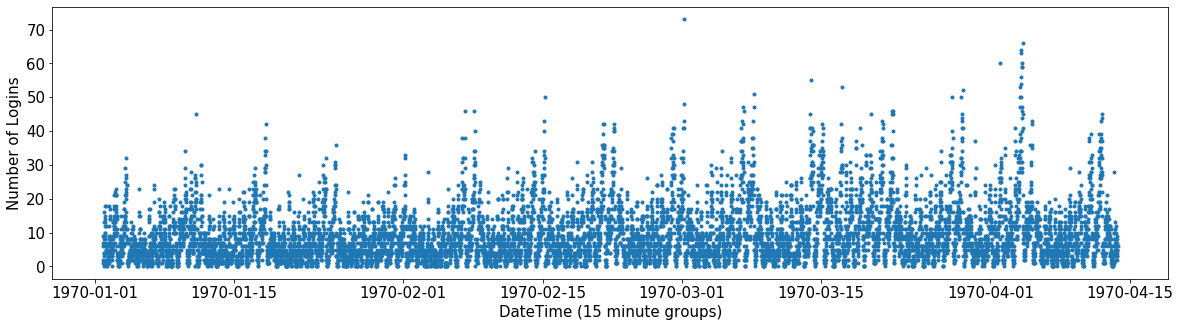

In [4]:
# Perform Exploratory Data Analysis: Time vs Count
plt.figure(figsize=(20,5)) # allow plot to take up entire notebook
plt.plot('login_time', 'count_ind', data=counts, marker='.', linestyle='None')
plt.ylabel('Number of Logins', fontsize=15)
plt.xlabel('DateTime (15 minute groups)', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

It appears as though there is a cyclic pattern in the data, when grouped into 15 minute intervals. There only appears to be one extreme value, of about 70 logins in 15 minutes in March of 1970. It also appears that the number of logins increases over time, with higher login rates in April 1970 compared to January 1970. This could be a function of the website/application gaining traction, or perhaps something else. It does appear that these dates are not correct, because the next dataset in this prompt has dates in 2014. I will assume that the times/months are correct for these data, but the years may have been added to the database incorrectly.

I will next look at how the number of logins changes over the course of a single day.

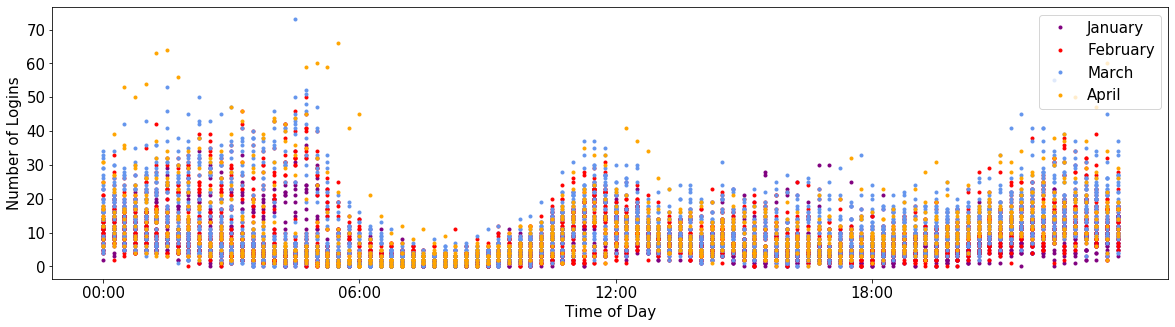

In [5]:
# Create month and time columns for easier plotting
counts['month'] = counts.login_time.dt.month
counts['time'] = counts.login_time.dt.time

# Create some colors with which we can produce an aesthetically pleasing plot
colors = ['None', 'purple', 'red', 'cornflowerblue', 'orange']

# Exploratory Data Analysis: Time of Day vs Number of Logins, colored by Month
plt.figure(figsize=(20,5))
for month in counts.month.drop_duplicates(): # for each unique month
    plt.plot(counts.time[counts.month == month], counts.count_ind[counts.month==month], 
             # plot times corresponding to that month on the x axis, and the counts corresponding
             # to those month/times on the y axis
             color=colors[month], # use the month to select a color
            marker='.', linestyle='None', label=month) 
            # plot as points and label with the month
plt.xticks(['00:00:00', '06:00:00', '12:00:00', '18:00:00'], 
           ['00:00', '06:00', '12:00', '18:00'], fontsize=15)
    # regularize the xtick marks
plt.yticks(fontsize=15) # make the y axis easier to see
plt.legend(loc='upper right', labels=['January', 'February', 
                                      'March', 'April'], fontsize=15)
    # make the legend easier to understand by adding month names instead of numbers
plt.ylabel('Number of Logins', fontsize=15) # identify the y axis
plt.xlabel('Time of Day', fontsize=15) # identify the x axis
plt.show()

The above plot shows that across all months, there's a pretty similar trend. There appears to be a decent degree of mixing across months, because there is not a clear, easy to spot, difference in color groups. However, we should run a few simple analyses to see if all months show statistically similar numbers of logins. We'll move on to different times of day after that.

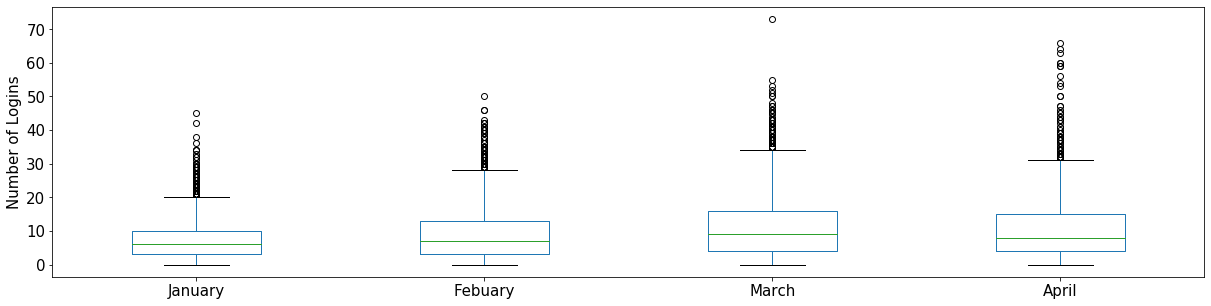

In [6]:
# Create a new column for months as a category, so that we can see the spread
# of data (quantiles) across different month groups
counts['monthF'] = counts.month.astype('category')

# Plot the results
counts.boxplot('count_ind', 'monthF', grid=False, figsize=(20,5), fontsize=15)
plt.xlabel('')
plt.ylabel('Number of Logins', fontsize=15)
plt.xticks([1,2,3,4], ['January', 'Febuary', 'March', 'April'])
    # rename the x axis so that it is easier to understand
plt.suptitle('')
plt.title('')
plt.show()

In [7]:
# Print some descriptive stats: Mean and STD for counts across Months
print(counts.groupby('monthF')['count_ind'].describe().loc[:,['mean','std']])

# Run an ANOVA
byMonth = pd.get_dummies(counts.loc[:,['monthF', 'count_ind']], drop_first=True)
    # one hot encoding via get dummies
byMonth['intercept'] = 1 # create an intercept value for the first category
byMonth_ols = sm.OLS(byMonth.loc[:,'count_ind'],byMonth.iloc[:,1:])
    # we want to use ordinary least squares
results = byMonth_ols.fit() # fit the model to the data
results.summary() # show results

             mean       std
monthF                     
1        7.333909  6.099863
2        9.178943  7.796656
3       11.331653  9.335820
4       10.999186  9.969840


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              count_ind   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     133.0
Date:                Fri, 31 Jan 2020   Prob (F-statistic):           1.81e-84
Time:                        17:16:06   Log-Likelihood:                -34440.
No. Observations:                9788   AIC:                         6.889e+04
Df Residuals:                    9784   BIC:                         6.892e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
monthF_2       1.8450      0.219      8.437      0.000       1.416       2.274
monthF_3       3.9977      0.213     18.757      0.000       3.580       4.416
monthF_4       3.6653      0.278     13.182      0.000       3.120       4.210
intercept      7.3339      0.152     48.335      0.000       7.036       7.631
==============================================================================
Omnibus:                     2939.470   Durbin-Watson:                   0.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9179.274
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                       6.602   Cond. No.                         4.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

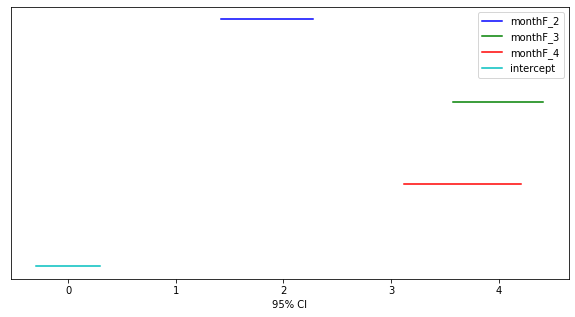

In [8]:
# Plot the results of the 95% CI from the ANOVA
plt.figure(figsize=(10,5))
plot_results(results)

There is a significant difference in traffic based on month. We can tell from the 95% CI and p-values from the ANOVA that January (month 1, the intercept, light blue line) is significantly different than all other months. January has the lowest number of logins compared to all other months. In addition, although Feburary (dark blue line) has significantly more logins than January, it has significantly less logins than March and April (the 95% CI for month 2 does not overlap with month 3 or 4). Finally, March and April (months 3 and 4, green and red lines) have statistically similar login rates, which are significantly higher than the previous two months. Perhaps this website has finally begun to gain traction, resulting in more logins in later months. 

Next, we will look at whether there are statistically significant differences in login rates across different hours of the day.

In [9]:
# Run ANOVA
byTOD = pd.get_dummies(counts.loc[:,['time', 'count_ind']], drop_first=False)
    # one hot encoding for time of day, do not remove the first value because
    # we will compare all values to 00:00:00 for simplicity
byTOD['intercept'] = 1 # add intercept axis
byTOD = byTOD.drop('time_00:00:00', axis=1) # drop the 00:00:00 so that it can
    # be represented by the intercept
byTOD_ols = sm.OLS(byTOD.loc[:,'count_ind'],byTOD.iloc[:,1:])
    # we want to use ordinary least squared
results = byTOD_ols.fit() # fit the model to the data

# Since there are a lot of categories, we should just print the results that
# we can group by usefulness.
print('Significantly greater than 00:00:00')
sigs = pd.DataFrame(results.params[(results.pvalues < 0.05) & (results.params > 0)]) 
sigs.columns = ['ParameterEstimate']
sigs['p'] = (results.pvalues[(results.pvalues < 0.05) & (results.params > 0)]) 
print(sigs) # print the results that are significantly greater than the login rate
    # at 00:00:00
print('\n')
print('Significantly less than 00:00:00')
sigs = pd.DataFrame(results.params[(results.pvalues < 0.05) & (results.params < 0)]) 
sigs.columns = ['ParameterEstimate']
sigs['p'] = (results.pvalues[(results.pvalues < 0.05) & (results.params < 0)]) 
print(sigs) # print the results that are significantly less than the login rate at
    # 00:00:00
print('\n')
print('Statistically similar to 00:00:00')
sigs = pd.DataFrame(results.params[(results.pvalues > 0.05)]) 
sigs.columns = ['ParameterEstimate']
sigs['p'] = (results.pvalues[(results.pvalues > 0.05)]) 
print(sigs) # print the results that are statistically similar to the login rate
    # at 00:00:00

Significantly greater than 00:00:00
               ParameterEstimate             p
time_01:30:00           2.294118  2.068328e-02
time_22:15:00           2.088235  3.519349e-02
time_22:30:00           2.401961  1.541630e-02
intercept              14.107843  2.778932e-88


Significantly less than 00:00:00
               ParameterEstimate             p
time_03:30:00          -2.715686  6.167610e-03
time_03:45:00          -3.401961  6.025673e-04
time_04:00:00          -3.009804  2.403646e-03
time_04:15:00          -2.696078  6.548592e-03
time_05:00:00          -2.607843  8.538085e-03
...                          ...           ...
time_19:45:00          -5.385071  6.151737e-08
time_20:00:00          -5.784314  5.561988e-09
time_20:15:00          -4.598039  3.562642e-06
time_20:30:00          -3.627451  2.545054e-04
time_20:45:00          -2.196078  2.676932e-02

[62 rows x 2 columns]


Statistically similar to 00:00:00
               ParameterEstimate         p
time_00:15:00           1.05

This output indicates that there is a signficant difference in login rates over the course of one day. It appears that rates in the early morning (between 21:00 and about 04:00) are the highest, with another peak around 11:00 - 13:00. We can see from one of our preliminary figures and the ANOVA results, that values are lowest between about 05:00 to 10:00. There could be several explinations for this. The first is that these data are recorded in UTC time, but the website is only used by a particular region, which has a different time zone. Perhaps this website is used primarily by southern California residents, where peaks would actually be between 13:00 and 20:00 local time and the second peak corresponds to another user demographic in yet another time zone. Alternatively, it is possible that the time zone is correct, and most people are using the service to drive/be driven after a night out.

Next, we should see whether login rates change over days of the week. If this website is used primarily for business ventures, it's likely that we would see a much lower login rate during the weekend (Saturday and Sunday). If it is used by people who need a designated driver for a night out, or for people who are using the site as a secondary job, there will likely be higher login rates during the weekend.

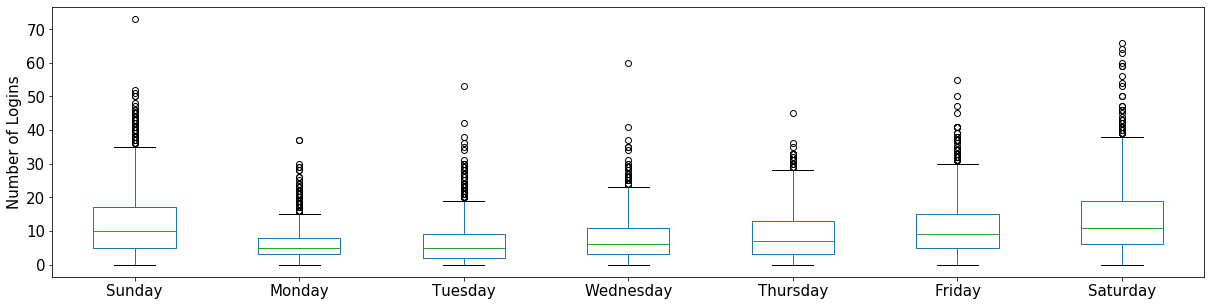

In [10]:
# Create a new column that parsese the dates into days of the week
counts['DOW'] = counts['login_time'].dt.strftime('%A')

# Conduct some cleaning so that the days of the week are displayed in
# calendar order
DOW_dtype = pd.api.types.CategoricalDtype(
    categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                'Thursday', 'Friday', 'Saturday'], 
    ordered=True)
counts['DOW'] = counts['DOW'].astype(DOW_dtype) # reclassify the day of 
    # week column so that it is organized properly
    
# Create a boxplot of login rates across days of week
counts.boxplot('count_ind', 'DOW', grid=False, figsize=(20,5), fontsize=15)
plt.xlabel('')
plt.ylabel('Number of Logins', fontsize=15)
plt.suptitle('')
plt.title('')
plt.show()

Right now, it looks like there actually may be higher login rates as the week progresses, with the highest login rates occuring on Saturday and Sunday. We run an ANOVA below to look into this question.

In [11]:
# Print some descriptive stats: Mean and STD for login rate across days of week
print(counts.groupby('DOW')['count_ind'].describe().loc[:,['mean','std']])

# Run ANOVA
byDOW = pd.get_dummies(counts.loc[:,['DOW', 'count_ind']], drop_first=True)
    # one hot encoding for day of the week, dropping the first value (Sunday)
byDOW['intercept'] = 1 # create intercept to house information about Sunday
byDOW_ols = sm.OLS(byDOW.loc[:,'count_ind'],byDOW.iloc[:,1:])
    # we want to use ordinary least squares
results = byDOW_ols.fit() # fit the model to the data
results.summary() # show the results

                mean        std
DOW                            
Sunday     12.615972  10.091680
Monday      6.213380   5.029465
Tuesday     6.895833   6.264071
Wednesday   7.692708   6.567372
Thursday    8.794118   7.058483
Friday     10.561111   8.172082
Saturday   13.456250  10.357784


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              count_ind   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     180.4
Date:                Fri, 31 Jan 2020   Prob (F-statistic):          1.27e-218
Time:                        17:16:07   Log-Likelihood:                -34122.
No. Observations:                9788   AIC:                         6.826e+04
Df Residuals:                    9781   BIC:                         6.831e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
DOW_Monday       -6.4026      0.296    -21.656      0.000      -6.982      -5.823
DOW_Tuesday      -5.7201      0.300    -19.078      0.000      -6.308      -5.132
DOW_Wednesday    -4.9233      0.300    -16.420      0.000      -5.511      -4.336
DOW_Thursday     -3.8219      0.299    -12.786      0.000      -4.408      -3.236
DOW_Friday       -2.0549      0.295     -6.975      0.000      -2.632      -1.477
DOW_Saturday      0.8403      0.295      2.852      0.004       0.263       1.418
intercept        12.6160      0.208     60.559      0.000      12.208      13.024
==============================================================================
Omnibus:                     2753.427   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8454.041
Skew:                           1.448   Prob(JB):                         0.00
Kurtosis:                       6.513   Cond. No.                         7.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

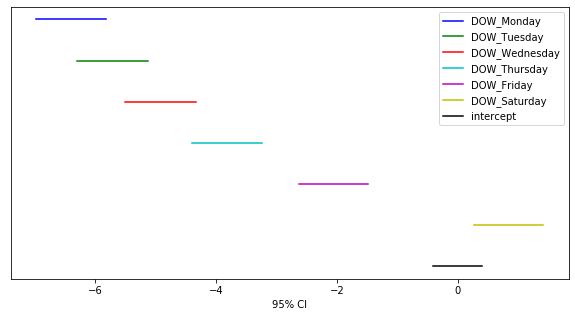

In [12]:
# Plot the results of the 95% CI from the ANOVA
plt.figure(figsize=(10,5))
plot_results(results)

We can see from the model results that nearly all days of the week have statistically different login rates; no 95% CI obviously overlap. Compared to Sunday, it appears that Saturday (gold line) has a significantly higher login rate, while all other days of the week have significantly lower login rates. Monday (dark blue line) appears to have the lowest login rate. Our initial hypothesis that login rates increased as the week wore on (potentially starting the week on Monday) appears to be supported by the ANOVA results. This make sense, because if most people are using Ultimate during the early hours of the morning, it is possible that these people have been going out on the weekend and need a safe ride home.

## Part 2: Experiment and Metrics Design

Prompt: The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

<b>1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b>

For this problem, I assume that the toll bridge is similar to FasTrack in the US, in which driver licence plate values are collected each time a car travels across the toll bridge. I also assume that driver partners are using the same car to travel between the cities. Thererfore, I think that the key measure of success for this experiment is to count the number of times that parter drivers make transitions between the cities.

<b>2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: a) how you will implement the experiment, b) what statistical test(s) you will conduct to verify the significance of the observation, c) how you would interpret the results and provide recommendations to the city operations team along with any caveats. </b>
    
<b>Implementation:</b> I propose that each driver partner allows his or her licence plate information to be gathered by the company. Each time a drive moves between cities, the licence plate value and the date, time, city traveling from, and city traveling to, shall also be recorded. If the toll bridge is operated by humans, the operators need to take special care to ensure that the licence plate numbers are recorded correctly. An alternative method would be scanning the IDs of the driver partner at the toll booth instead of gathering licence plate information. This experiment should take place across all days of the week, all times of day, and ideally, over several months and seasons (individuals may be traveling more or less during holidays). Throughout the study, toll prices should be alternated each day to either charge driver partners or allow passage without a charge. By alternating each day, the risk associated with correlation between particular days of the week or particular seasons is minimized. However, since it may be more costly to implement an alternating schedule such as the one provided, a different alternating schedule may be implemented. Charge prices should be the same across all days in which vehicles are charged.

<b>Statstical Tests:</b> The resulting dataset from this experiment would have the following columns: Date, Time, Licence Plate (or Driver Name), City Traveling From, City Traveling To, and whether or not the individual was charged. The first step to analyzing these data would be to run some exploratory data analyses to ensure that all data were recorded correctly. If there are particular licence plates/drivers that did not make many trips across the toll bridge throughout the entire study (less than 5, but may change depending on the dataset), those entires should be removed from the dataset. We can then split the data into groups based on whether the individual was charged a toll fee or whether the individual was allowed to pass, free of charge. We can compare the number of times transitions were made during times of 'toll fees' and times of 'free tolls' using a t-test. This will give us an overall idea of whether removing fees makes driver partners more willing to cross the toll bridge. However, there are several other things that may be going on in this dataset, so other statistical analyses may help to shed light on other confounding factors that may affect the results. We can compare directions of travel (Gotham --> Metropolis, Metropolis --> Gotham) during times of the same toll schedule (compare during times of 'toll fees' and during times of 'free tolls') using a t-test to see whether one city was contributing more to the model results than the other. Another useful statistic would be a generalized linear mixed model. Toll counts would be the response variable (with a poisson distribution), with travel direction (categorical, Gotham --> Metropolis, Metropolis --> Gotham), time of day (hours), month (categorical, derived from date), toll price (categorical, paid or free), day of the week (categorical) as predictor variables. In addition, because the same individuals are making these transitions day after day, we would introduce a random variable of (1|licence plate or name). Adding this last section would help to balance results that may be biased due to one or two people skewing the dataset.

<b>Intrepretation of Results: </b>The most important question we need to answer is whether or not providing free toll fares to driver partners is going to be worth the time and money. Perhaps our statistical tests will tell us that it doesn't matter to driver partners whether the toll bridge is free or not during times of peak activity in each city (during the night in Gotham and the day in Metropolis). However, during times of little activity (during the day in Gotham and the night in Metropolis), providing free toll fare may be a key component to getting more people to make the transition between the cities. In this scenario, the city partners may want to make tolls free for driver partners who are traveling from Metropolis to Gotham during the day (on the weekdays) and who are traveling from Gotham to Metropolis during the night (on weekdays). Alternatively, perhaps our generalized linear mixed model indicates that there is more travel between the cities during the winter season, regardless of toll fees, when people are getting ready for the holidays. In this instance, the city managers may want to continue to collect fees from driver partners during this time period. Finally, if our results show that during the weekends, people are still willing to drive between cities, regardless of toll fees, the city managers may choose to continue collecting fees during this time, when people may be more likely to be traveling across cities for pleasure. Alternatively, it may be useful to remove fees during work-days, when people are more likely to stay in their home city to go to work, and not travel to another city on their lunch break or for happy hour.

## Part 3: Predictive Modeling

Prompt: Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

In [13]:
# Load in dataset
import json # pandas read_json isn't working

# Open file as a string
file=open('ultimate_challenge/ultimate_data_challenge.json', 'r')
file_content=file.read() 
file.close()

# Read it in with json loads
data=json.loads(file_content)

# Create pandas dataframe
ult=pd.DataFrame(data)

<b>1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? </b>

In [14]:
# See if there are any NaNs
ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


It appears that we have missing data for the average rating of the individual when he/she is a driver, the kind of phone that the individual has, and the average rating of the individual when he/she is a rider. This could be a big factor in our dataset, because if someone is not being rated, it might mean that this person is not using the application frequently and is likely not going to be active in the future; he or she may even delete the application. I think to tackle this problem, we should convert these columns into categories, if they're not categories already. For the ratings, we can split the data into 5 bins: 0-1 star, 1-2 stars, 2-3 stars, 4-5 stars, and 'Not rated'. To accomplish this grouping, we need to first round the ratings to the ceiling (1.1 would be in considered 1-2 stars, while 0.9 would be considered 0-1 stars) and then convert this into a categorical column. For the phone type, we can add another category 'Unknown'. We want to keep data from 'Unknown' phone types, because its possible that phones that are not as popular as Androids or iPhones do not work well with the ride application. 

In [15]:
# Fix NA values for rating as a driver
ult['avg_rating_of_driver_cat'] = ult.avg_rating_of_driver.apply(np.ceil).astype('category')
ult['avg_rating_of_driver_cat'].cat.rename_categories(['0-1', '1-2', '2-3', '3-4', '4-5'], inplace=True)
ult['avg_rating_of_driver_cat'].cat.add_categories(['Not Rated'], inplace=True)
ult['avg_rating_of_driver_cat'].fillna('Not Rated', inplace=True)

# Fix NA values for rating as a rider
ult['avg_rating_by_driver_cat'] = ult.avg_rating_by_driver.apply(np.ceil).astype('category')
ult['avg_rating_by_driver_cat'].cat.rename_categories(['0-1', '1-2', '2-3', '3-4', '4-5'], inplace=True)
ult['avg_rating_by_driver_cat'].cat.add_categories(['Not Rated'], inplace=True)
ult['avg_rating_by_driver_cat'].fillna('Not Rated', inplace=True)

# Fix NA values for phones
ult['phone'] = ult.phone.astype('category')
ult['phone'].cat.add_categories(['Unknown'], inplace=True)
ult['phone'].fillna('Unknown', inplace=True)

# Remove non-categorical columns
ult = ult.drop(['avg_rating_of_driver', 'avg_rating_by_driver'], axis=1)

Although these data are useful, I think another metric that might be useful is something like 'application duration', or how long it has been since the user signed up for the service until the user's most recent interaction with the application. 

In [16]:
# Convert dates to datetime objects
ult['signup_date'] = pd.to_datetime(ult['signup_date'])
ult['last_trip_date'] = pd.to_datetime(ult['last_trip_date'])

# Calculate the days since sign up to the last trip date
ult['days_since_signup'] = (ult['last_trip_date'] - ult['signup_date']).dt.days

Now we can begin to see what the data look like.

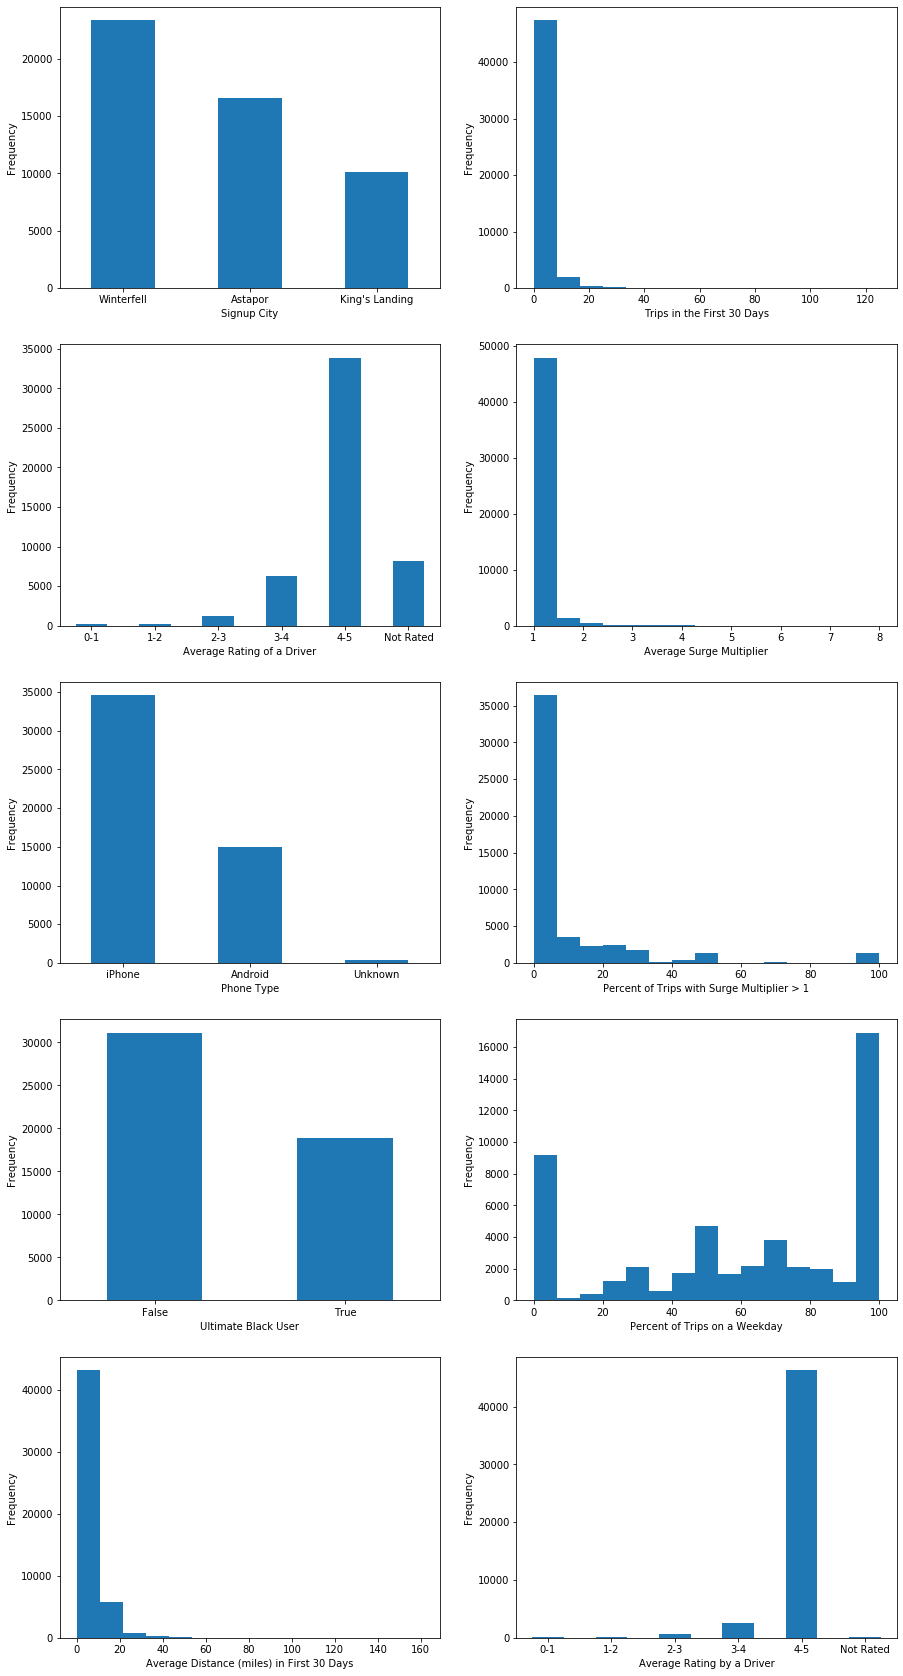

In [17]:
# Plot frequency counts
fig, axs = plt.subplots(5,2, figsize=(15,30))

# Signup cities
ult['city'].value_counts().plot(kind='bar', ax=axs[0,0])
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=0)
axs[0,0].set_xlabel('Signup City')

# Trips in first 30 days
ult['trips_in_first_30_days'].plot(kind='hist', bins=15, ax=axs[0,1])
axs[0,1].set_xlabel('Trips in the First 30 Days')

# Rating of Driver
ult['avg_rating_of_driver_cat'].value_counts(sort=False).plot(kind='bar', ax=axs[1,0])
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=0)
axs[1,0].set_xlabel('Average Rating of a Driver')

# Average surge
ult['avg_surge'].plot(kind='hist', bins=15, ax=axs[1,1])
axs[1,1].set_xlabel('Average Surge Multiplier')

# Phone type
ult['phone'].value_counts().plot(kind='bar', ax=axs[2,0])
axs[2,0].set_ylabel('Frequency')
axs[2,0].set_xticklabels(axs[2,0].get_xticklabels(), rotation=0)
axs[2,0].set_xlabel('Phone Type')

# Surge Percent
ult['surge_pct'].plot(kind='hist', bins=15, ax=axs[2,1])
axs[2,1].set_xlabel('Percent of Trips with Surge Multiplier > 1')

# Special Users
ult['ultimate_black_user'].value_counts().plot(kind='bar', ax=axs[3,0])
axs[3,0].set_ylabel('Frequency')
axs[3,0].set_xticklabels(axs[3,0].get_xticklabels(), rotation=0)
axs[3,0].set_xlabel('Ultimate Black User')

# Percent of trips on a weekday
ult['weekday_pct'].plot(kind='hist', bins=15, ax=axs[3,1])
axs[3,1].set_xlabel('Percent of Trips on a Weekday')

# Average Distance in the First 30 Days
ult['avg_dist'].plot(kind='hist', bins=15, ax=axs[4,0])
axs[4,0].set_xlabel('Average Distance (miles) in First 30 Days')

# Rating by Drivers
ult['avg_rating_by_driver_cat'].value_counts(sort=False).plot(kind='bar', ax=axs[4,1])
axs[4,1].set_ylabel('Frequency')
axs[4,1].set_xticklabels(axs[4,1].get_xticklabels(), rotation=0)
axs[4,1].set_xlabel('Average Rating by a Driver')

plt.show()

All data were retained in the dataset, because it's important to be able to use as much data as possible, particularly for more accurate analyses. I then plotted the frequency of data points within each category or bins for numerical data (illustrated above). Although there are differences in the proportions of data that fall into different categories, groups like signup city and whether the individual is an Ultimate Black User have enough data points across groups that we can still compare them. There does seem to be some categories with few data points in groups like: phone type (unknown phone types are low) and average rating by a driver (groups for 0-1, 1-2, and not rated have few data points). There also seems to be some sort of distribution across the percentage of trips that take place on a weekday. It appears that either people are using the application only during the week or only on the weekends. This probably represents two groups of people (using the application for work vs using the application for fun). I am going to keep all parameters in the dataset for now, but note that our results should be taken with a grain of salt, because some relationships may be driven by difference in the number of samples per category.

Next, I will see if there is a relationship between the time between the signup and the last trip and the number of trips in the first 30 days compared to other categorical variables, like the type of phone, average ratings, Ultimate Black Users, etc.

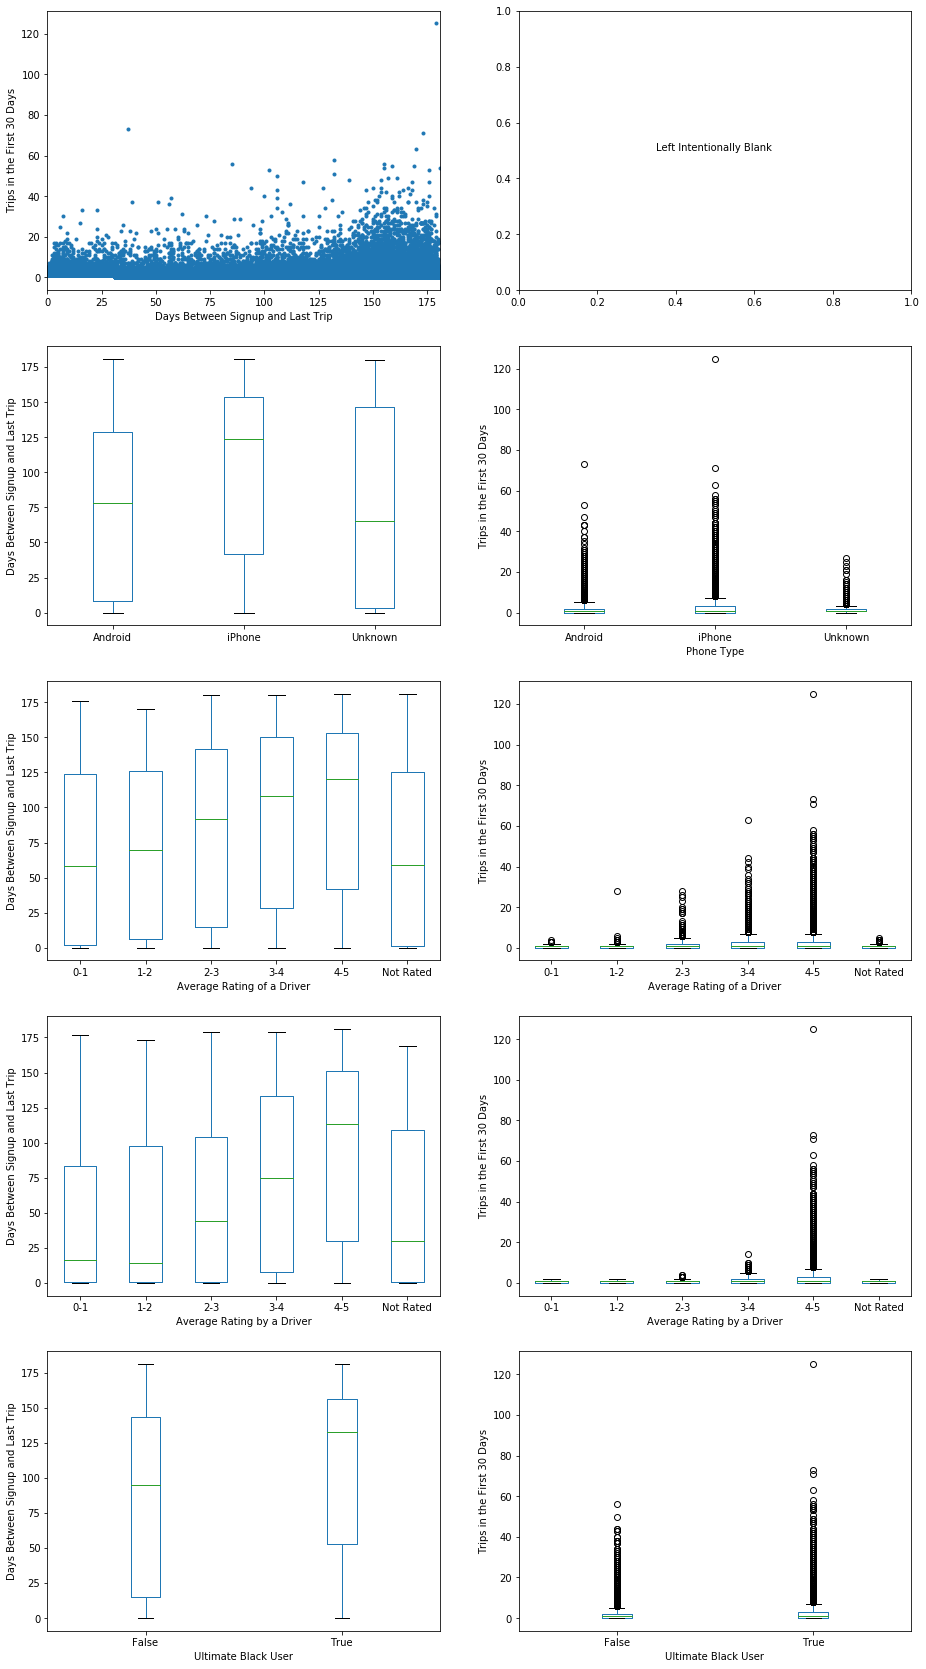

In [18]:
# Plot some relationships
fig, axs = plt.subplots(5,2, figsize=(15,30))

# Days between signup and last trip vs trips in the first 30 days
ult.plot('days_since_signup', 'trips_in_first_30_days', linestyle='None', marker='.', legend=False, ax=axs[0,0])
axs[0,0].set_ylabel('Trips in the First 30 Days')
axs[0,0].set_xlabel('Days Between Signup and Last Trip')

# Blank so that the following plots can be compared side by side
axs[0,1].text(0.35, 0.5, 'Left Intentionally Blank')

# Days between signup and last trip vs phone type
ult.boxplot('days_since_signup', 'phone', grid=False, ax=axs[1,0])
axs[1,0].set_title('')
axs[1,0].set_ylabel('Days Between Signup and Last Trip')
axs[1,0].set_xlabel('')

# Number of trips in the first 30 days vs phone type
ult.boxplot('trips_in_first_30_days', 'phone', grid=False, ax=axs[1,1])
axs[1,1].set_title('')
axs[1,1].set_ylabel('Trips in the First 30 Days')
axs[1,1].set_xlabel('Phone Type')

# Days between signup and last trip vs average rating of driver
ult.boxplot('days_since_signup', 'avg_rating_of_driver_cat', grid=False, ax=axs[2,0])
axs[2,0].set_title('')
axs[2,0].set_ylabel('Days Between Signup and Last Trip')
axs[2,0].set_xlabel('Average Rating of a Driver')

# Number of trips in the first 30 days vs average rating of driver
ult.boxplot('trips_in_first_30_days', 'avg_rating_of_driver_cat', grid=False, ax=axs[2,1])
axs[2,1].set_title('')
axs[2,1].set_ylabel('Trips in the First 30 Days')
axs[2,1].set_xlabel('Average Rating of a Driver')

# Days between signup and last trip vs average rating by driver
ult.boxplot('days_since_signup', 'avg_rating_by_driver_cat', grid=False, ax=axs[3,0])
axs[3,0].set_title('')
axs[3,0].set_ylabel('Days Between Signup and Last Trip')
axs[3,0].set_xlabel('Average Rating by a Driver')

# Number of trips in the first 30 days vs average rating by driver
ult.boxplot('trips_in_first_30_days', 'avg_rating_by_driver_cat', grid=False, ax=axs[3,1])
axs[3,1].set_title('')
axs[3,1].set_ylabel('Trips in the First 30 Days')
axs[3,1].set_xlabel('Average Rating by a Driver')

# Days between signup and last trip vs whether individual is an ultimate black user
ult.boxplot('days_since_signup', 'ultimate_black_user', grid=False, ax=axs[4,0])
axs[4,0].set_title('')
axs[4,0].set_ylabel('Days Between Signup and Last Trip')
axs[4,0].set_xlabel('Ultimate Black User')

# Number of trips in the first 30 days vs whether individual is an ultimate black user
ult.boxplot('trips_in_first_30_days', 'ultimate_black_user', grid=False, ax=axs[4,1])
axs[4,1].set_title('')
axs[4,1].set_ylabel('Trips in the First 30 Days')
axs[4,1].set_xlabel('Ultimate Black User')

# Remove plot sup title and show plot
plt.suptitle('')
plt.show()

There does not really seem to be a relationship between the number of days between an individual's sign up date and the most recent ride date and the number of trips in the first 30 days. This likely means that users that are staying with the application for longer aren't necessarily the ones that started off 'strong' using the service. We repeatedly see that in these plots, the figures that show the differences in days between the signup date and the last trip (the consistency of use) shows clearer trends than using the trips in the first 30 days. Since our ultimate goal of Question 2 is the retention of users, I think that the days between the signup and the last trip (application duration) is a good component to add. Even though there are few 'other' phone users, the variation in application duration is quite high. There may be a significant relationship here (we could do an ANOVA to see), where it seems like iPhone users may have higher application durations than Android Users. For average ratings by and for a driver, it appears that there's higher application duration for users with higher ratings (3-4, 4-5) and lower application duration for users with no ratings (Not Rated). Again, we could test this using an ANOVA to see if results are significant. Finally, it appears that most people who are Ultimate Black Users have a higher application duration; likely because once users become part of an elite club, they either spend more money on the application and have more incentive to use it, or have been promoted to the club because they use it more. To see if this difference is significant, we could use a t-test.


<b>2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</b>

In [19]:
# Import machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

In [20]:
# Build an easy function to get precision and recall
# from the confusion matrix
def precision_recall_calc(true, predicted):
    """"""" Calculates precision and recall scores for a particular model """""""
    cm = confusion_matrix(true, predicted)
    p = cm[0,0]/(cm[0,0] + cm[1,0])
    r = cm[0,0]/(cm[0,0] + cm[0,1])
    return p, r

I think that one method to answer this question is to use supervised machine learning with a categorical response variable. Although we don't have labeled data, we can predict what the labels might look like. I hypothesize that if someone has been active for at least 5 months, it's likely that they will continue to be active during their 6 month of registration with the application. So the response variable for this model will be a categorical variable (0: No, 1: Yes) as to whether or not this individual is active at 5 months. I will include all predictor variables in the model and see which factors are most important in model precision.

In [21]:
# Create a predictor variable 
ult['active_5mo'] = 0 # start with 0 for all rows
ult.loc[ult.days_since_signup >= 150, 'active_5mo'] = 1
    # if someone's last trip was at least ~5 months (30 days*5) since they
    # signed up, assign it a 1
ult['active_5mo'] = ult['active_5mo'].astype('category') # convert to categories

# Separate into response and predictor datasets
response = ult.loc[:,'active_5mo'].copy()
predictors = ult[['city', 'trips_in_first_30_days', 'avg_surge', 'phone', 
                  'surge_pct', 'ultimate_black_user','weekday_pct','avg_dist', 
                  'avg_rating_of_driver_cat', 'avg_rating_by_driver_cat']].copy()

# Use one-hot encoding for categorical variables
predictors = pd.get_dummies(predictors, drop_first=True)

In [22]:
# Split dataset into training set and test set to see model performance
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.25, random_state=33) 

I am going to use a Gradient Boosting algorithm to try and predict whether someone will be active five months after signing up from all of the predictors in the model. I chose the Gradient Boosting algorithm because it often yields more precise measurements than a single Decision Tree, but it can also give me an idea of which parameters are driving the model the most. K Nearest Neighbors is also a good option, as it may yield more precise results. However, K Nearest Neighbors does not allow me to see which factors are most important, and would make it difficult for me to give 'next steps' to the client.

I'll begin by doing a quick grid search to see which hyperparameters to use for the model.

In [23]:
# Grid Search for gradient boosting
parameters = {'learning_rate':[0.075, 0.1, 0.25, 0.5, 0.75], 'n_estimators':[10, 50, 100], 
             'max_depth':[3,6,8]}
    # Set parameters
gb = GradientBoostingClassifier()
    # set classifier
clf = GridSearchCV(gb, parameters, cv=5)
    # run grid search with a fold of 5
clf.fit(X_train, y_train) # fit to the data
print(clf.best_params_) # get the best parameters

{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}


The hyperparameters that seem to be the best are: learning rate of 0.5, max depth of 3, and n_estimators of 100. The learning rate is a little bit high, but the max depth is low, which means that if we did want to see the exact splits in a single tree within the model, it would be pretty easy to interpret. This may indicate that just one or two factors are important in the classification of the response variable.

In [24]:
# Create model
gb = GradientBoostingClassifier(learning_rate=0.5, max_depth=3, n_estimators=100)
gb.fit(X_train, y_train) # train the data

# Get the prediction values for the training and testing data
y_pred_train = gb.predict(X_train)
y_pred = gb.predict(X_test)

# Print results
print('Training Precision: ' + str(precision_recall_calc(y_train, y_pred_train)[0]))
print('Testing Precision: ' + str(precision_recall_calc(y_test, y_pred)[0]))

Training Precision: 0.8385219668315391
Testing Precision: 0.827891156462585


We see that the precision for the testing and the training datasets are pretty high (about 0.83 for both). This is good, because our testing precision is nearly as high as our training precision. This means that the model is likely not overfitting the training data.

Next, I will see which four parameters are the most important. Four parameters was an arbitrary choice; we could look at more if we want to.

In [25]:
features = pd.DataFrame({'feature':X_train.columns, 
                         'importance':gb.feature_importances_})
    # create data frame of feature importances
features = features[features.importance > 0].sort_values(
    by='importance',ascending=False).reset_index(drop=True)
    # only keep those > 0 and sort by importance
print(features[0:4]) # print

               feature  importance
0            surge_pct    0.380094
1          weekday_pct    0.240298
2  city_King's Landing    0.087953
3         phone_iPhone    0.078332


It seems like the percent of trips with a surge multiplier > 1, the percent of trips during the week, signing up in King's Landing, and having an iPhone are all factors that are driving the model to predict the proper category. Below, I plot the relationships to see if I can figure out how these factors are influencing the response.

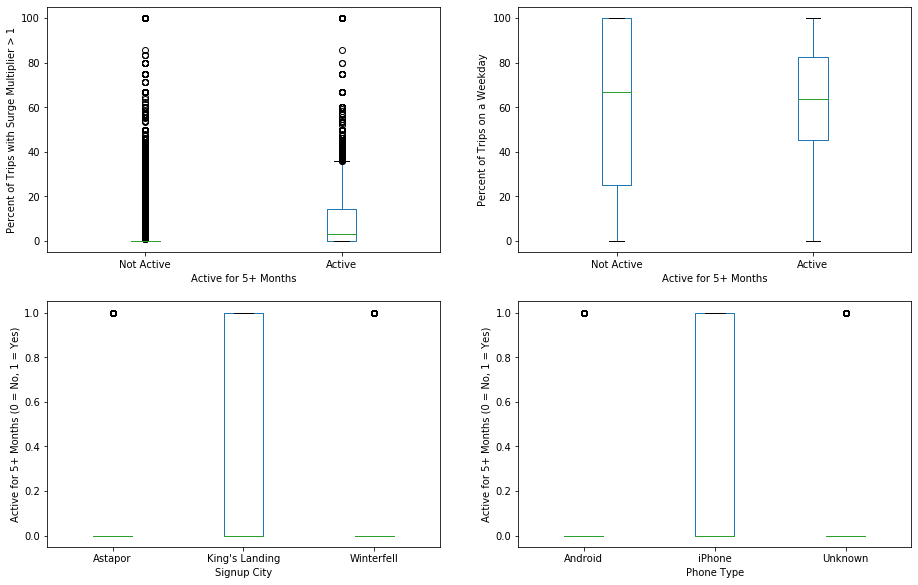

In [26]:
# Set up plot with subplots
fig, axs = plt.subplots(2,2, figsize=(15,10))

# Surge percent vs active for five months
ult.boxplot('surge_pct', 'active_5mo', grid=False, ax=axs[0,0])
axs[0,0].set_xlabel('Active for 5+ Months')
axs[0,0].set_ylabel('Percent of Trips with Surge Multiplier > 1')
axs[0,0].set_title('')
axs[0,0].set_xticklabels(['Not Active', 'Active'])

# Weekday percent vs active for five months
ult.boxplot('weekday_pct', 'active_5mo', grid=False, ax=axs[0,1])
axs[0,1].set_xlabel('Active for 5+ Months')
axs[0,1].set_ylabel('Percent of Trips on a Weekday')
axs[0,1].set_title('')
axs[0,1].set_xticklabels(['Not Active', 'Active'])

# City vs active for five months
ult['active_5mo_num'] = ult['active_5mo'].astype(int)
    # make a new column for 5mo as an integer because we can't plot
    # two categories against each other
ult.boxplot('active_5mo_num', 'city', grid=False, ax=axs[1,0])
axs[1,0].set_xlabel('Signup City')
axs[1,0].set_ylabel('Active for 5+ Months (0 = No, 1 = Yes)')
axs[1,0].set_title('')

# Phone type vs active for give months
ult.boxplot('active_5mo_num', 'phone', grid=False, ax=axs[1,1])
axs[1,1].set_xlabel('Phone Type')
axs[1,1].set_ylabel('Active for 5+ Months (0 = No, 1 = Yes)')
axs[1,1].set_title('')

# Remove sup title and show plots
plt.suptitle('')
plt.show()

These plots indicate that most users that are still active after five months have more trips with surge multipliers > 1 (when demand is high and prices go higher). This may mean that the people using the application are drivers, who are trying to make more money, or that the people using the application are riders and are not bothered with higher prices during peak hours. It also appears that users that are not as active on the application vary in when they use the app; there is a high variation in the percent of trips that happen on a weekday. Alternatively, it seems like active users are more reliable in their use patterns, and most of them seem to use the application during weekdays. It also appears like users who signed up in Kings Landing and users who are using iPhones are most likely to be using the application for 5+ months. 


<b>3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).</b>

The results from this model indicates that 'long term customers' are individuals who are using the application during peak periods (when surge multipliers are high), who use the application during the weekdays about 45%-85% of the time, who originated from King's Landing, and who have iPhones. Although these data represent people who have been using the application for 5+ months, it is possible that these people may or may not continue to use the app during the next month. In this test, we will assume that individuals who have made it 5 months have a high likelihood of continuing their use next month. If Ultimate wants to focus on keeping people interested in the application, perhaps they should look into using smaller surge multipliers (to keep users who may not think paying more money is worth the ride), into making rides more affordable during the week (to encourage users to use the application to go to work), adding more advertising in Astapor or Winterfell to entice new users from those regions, and make sure that their application works well on Android phones. It may be that Android phones are not compatible with the current application version, causing users to stop using it right away.